### Sentinel-3 Level-2 altimetry data visualization.
#### Data download from: https://scihub.copernicus.eu/dhus/#/home


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
import netCDF4 as nc
import numpy as np
from utils.time_to_dyr import time_to_dyr

In [3]:
## s3 data
path_s3l2 = 'data/sentinel-3/s3a-orbit-289/S3A_SR_2_LAN____20200523T030933_20200523T035741_20200617T203903_2888_058_289______LN3_O_NT_004.SEN3/enhanced_measurement.nc'
path_s3l2_subs = 'data/sentinel-3/s3a-orbit-289/S3A_SR_2_LAN____20200523T030933_20200523T035741_20200617T203903_2888_058_289______LN3_O_NT_004.SEN3/enhanced_measurement_subs.nc'
path_s3l2_merge = 'data/sentinel-3/s3a-orbit-289/enhanced_measurement_readout_subs_merge.h5'
## remote sensing data
path_rsimg = 'data/rs-img/dianchi_s2_20200511_wgs84.tif'
path_rsimg_wat = 'data/water_mask/dianchi_s2_20200511_wat_wgs84.tif'


### Data reading

In [4]:
# !h5ls $path_s3l2_merge


In [5]:
## 1. s3l2 altimetry data
s3_l2 = nc.Dataset(path_s3l2)   ##
## 2. remote sensing image
rs_img, rs_img_info = readTiff(path_rsimg)
rs_wat, rs_wat_info = readTiff(path_rsimg_wat)


In [6]:
s3_l2.variables.keys()


odict_keys(['time_01', 'time_20_ku', 'time_20_c', 'echo_sample_ind', 'UTC_day_01', 'UTC_sec_01', 'UTC_day_20_ku', 'UTC_sec_20_ku', 'UTC_day_20_c', 'UTC_sec_20_c', 'UTC_time_1hz_20_ku', 'UTC_time_1hz_20_c', 'lat_01', 'lon_01', 'lat_20_ku', 'lon_20_ku', 'lat_20_c', 'lon_20_c', 'lat_cor_20_ku', 'lon_cor_20_ku', 'lat_cor_20_c', 'lon_cor_20_c', 'surf_type_01', 'surf_type_20_ku', 'surf_type_20_c', 'surf_class_01', 'surf_class_20_ku', 'surf_class_20_c', 'rad_surf_type_01', 'dist_coast_01', 'dist_coast_20_ku', 'dist_coast_20_c', 'alt_01', 'alt_20_ku', 'alt_20_c', 'orb_alt_rate_01', 'orb_alt_rate_20_ku', 'orb_alt_rate_20_c', 'tracker_range_20_ku', 'tracker_range_20_c', 'tracker_range_20_plrm_ku', 'h0_nav_dem_20_ku', 'agc_01_ku', 'agc_01_c', 'agc_01_plrm_ku', 'agc_20_ku', 'agc_20_c', 'agc_20_plrm_ku', 'agc_numval_01_ku', 'agc_numval_01_c', 'agc_numval_01_plrm_ku', 'agc_rms_01_ku', 'agc_rms_01_c', 'agc_rms_01_plrm_ku', 'agc_qual_20_ku', 'agc_qual_20_c', 'agc_qual_20_plrm_ku', 'scale_factor_20_ku'

In [8]:
lat_20_ku = s3_l2['lat_20_ku'][:]
lon_20_ku = s3_l2['lon_20_ku'][:]
time_20_ku = s3_l2['time_20_ku'][:]
waveform_20_ku = s3_l2['waveform_20_ku'][:]
time_20_ku_dyr =time_to_dyr(time_20_ku)
print(lon_20_ku.shape, lat_20_ku.shape, time_20_ku_dyr.shape)  ## number of data
print(waveform_20_ku.shape)  ## waveform
time_20_ku
time_20_ku_dyr

(34445,) (34445,) (34445,)
(34445, 128)


array([2020.39107104, 2020.39107104, 2020.39107104, ..., 2020.39116238,
       2020.39116238, 2020.39116239])

#### Calculate the surface water height 

In [216]:
## 1. Correction: 1Hz
geo_corr_1hz=['iono_cor_gim_01_ku', 'mod_dry_tropo_cor_meas_altitude_01', 'mod_wet_tropo_cor_meas_altitude_01', 'ocean_tide_sol2_01', 'load_tide_sol2_01', 'solid_earth_tide_01', 'pole_tide_01']
corr_1hz = 0
for cor_1hz_name in geo_corr_1hz:
  corr_1hz += s3_l2[cor_1hz_name][:]
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = s3_l2['time_20_ku'][:]
times_01 = s3_l2['time_01'][:]
times_20_ = np.expand_dims(times_20, axis=1)
dif_time = abs(times_20_ - times_01)
ind_min = dif_time.argmin(axis=1)
corr_01to20 = corr_1hz[ind_min]
## 3. Calculate the corrected surface water height
## 3.1 ocean retracker
h_cor_ocean = s3_l2['alt_20_ku'][:] - s3_l2['range_ocean_20_ku'][:] - corr_01to20
h_cor_ocean = h_cor_ocean.filled(np.nan)
## 3.2 ocog retracker
h_cor_ocog = s3_l2['alt_20_ku'][:] - s3_l2['range_ocog_20_ku'][:] - corr_01to20
h_cor_ocog = h_cor_ocog.filled(np.nan)
## 3.3 ocog retracker(official given)
h_cor_ocog_ = s3_l2['elevation_ocog_20_ku']


### Visualization from global perspective

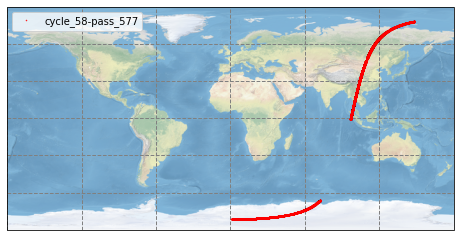

In [86]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=proj); ax.stock_img()
orbit = 'cycle_'+str(s3_l2.cycle_number)+'-pass_'+str(s3_l2.pass_number)
ax.plot(lon_20_ku, lat_20_ku, marker='.', markersize=1, 
                                linewidth=0.0, label=orbit, color='red')
ax.gridlines(linewidth=1, color='gray', linestyle='--')
ax.legend()


### Visualization from local perspective

Text(0.5, 1.0, 'merged data')

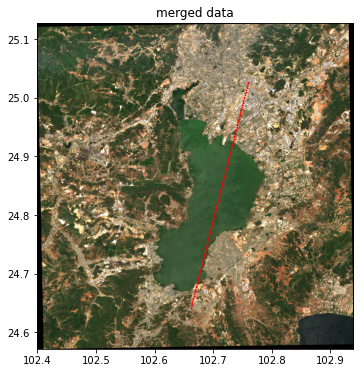

In [87]:
ids = np.where((lat_20_ku[:]>24.64) & (lat_20_ku[:]<25.03))  
fig = plt.figure(figsize=(6, 6))
plt.subplot(1,1,1)
imgShow(rs_img, extent=rs_img_info['geoextent'])
plt.scatter(x=lon_20_ku[ids], y=lat_20_ku[ids], s=0.5, color='red')  ## altimetry data
plt.title('merged data')


(1853.5, 1855.5)

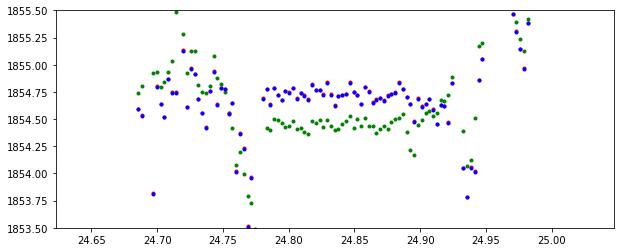

In [223]:
plt.figure(figsize=(10,4))
plt.plot(lat_20_ku[ids], h_cor_ocean[ids], 'g.')
plt.plot(lat_20_ku[ids], h_cor_ocog[ids], 'r.')
plt.plot(lat_20_ku[ids], h_cor_ocog_[ids], 'b.')
plt.ylim(1853.5, 1855.5)
